# Finding the Next Bestseller

## Project Goal

Using publicly available data fom Goodreads, Wikipedia, and Amazon, this project aims to acquire, explore, and analyze information about books - their popularity via online reviews and ratings, as well as keywords, author name, publisher, and more - to programmatically determine which factors lead to a book landing on the New York Times Bestseller list. 

## Project Creators:

- [Brandon Navarrete](https://github.com/brandontnavarrete)
- [Magdalena Rahn](https://github.com/MagdalenaRahn)
- [Manuel Parra](https://github.com/manuelparra1)
- [Shawn Brown](https://github.com/shawn-brown12)


## Table of Contents

   - [Acquire](#Acquire)
   - [Prepare](#prepare)
   - [Explore](#explore)
   - [Model](#model)
   - [Conclusions](#conclusions)

## Setting up the Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests
import unicodedata
import re
import os
import json

import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import nltk
#from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import prepare as prep
import explore as ex
# import modeling as m


## Acquisition

In [2]:
# This function sequentially runs each function from within the prepare.py file 
# in order to gather and clean the data, as well as creating our target variable and getting
# the sentiment analysis of the book summaries
df = prep.prep_data('all_books.csv')

In [3]:
# a quick peak at our dataframe
df.head()

,title,summary,year_published,author,review_count,number_of_ratings,length,genre,rating,reviews,cleaned_title,cleaned_summary,successful,lemmatized_summary,neg,neutral,pos,compound,sentiment
0,Missing in Death,"Aboard the Staten Island ferry, a tourist come...",2009,J.D. Robb,334,9875,77.0,Mystery,4.24,[],missing in death,"aboard the staten island ferry, a tourist come...",False,aboard staten island ferry tourist come across...,0.185,0.804,0.011,-0.9534,very negative
1,The Last Boyfriend,"Owen is the organizer of the Montgomery clan, ...",2012,Nora Roberts,2545,47392,436.0,Romance,4.09,[],the last boyfriend,"owen is the organizer of the montgomery clan, ...",False,owen organizer montgomery clan run family cons...,0.019,0.875,0.106,0.9388,very positive
2,Just Me in the Tub,Taking a bath is a big job. Mercer Mayer's fam...,1994,Gina Mayer,62,19212,24.0,Childrens,4.25,[],just me in the tub,taking a bath is a big job. mercer mayer's fam...,False,take bath big job mercer mayer famous little c...,0.008,0.781,0.211,0.9811,very positive
3,Lucy in the Sky,Settling down for a 24-hour flight to Australi...,2007,Paige Toon,628,9524,390.0,Chick Lit,3.95,[],lucy in the sky,settling down for a 24hour flight to australia...,False,settle flight australia lucy find text message...,0.068,0.679,0.253,0.9861,very positive
4,The Rats in the Walls,"""The Rats in the Walls"" is a short story by H....",1924,H.P. Lovecraft,531,9155,25.0,Horror,4.01,[],the rats in the walls,the rats in the walls is a short story by h.p....,False,rat wall short lovecraft write augustseptember...,0.015,0.985,0.000,-0.1779,negative


In [4]:
# saving the above df into a new csv file, so that we don't have to run it through again unless we add to our dataset.
df.to_csv('final_df.csv')

In [5]:
# pulling the data from the csv saved above
df = pd.read_csv('final_df.csv', index_col=0)

In [6]:
# a peak to compare the dataframe above and confirm they are the same
df.head()

,title,summary,year_published,author,review_count,number_of_ratings,length,genre,rating,reviews,cleaned_title,cleaned_summary,successful,lemmatized_summary,neg,neutral,pos,compound,sentiment
0,Missing in Death,"Aboard the Staten Island ferry, a tourist come...",2009,J.D. Robb,334,9875,77.0,Mystery,4.24,[],missing in death,"aboard the staten island ferry, a tourist come...",False,aboard staten island ferry tourist come across...,0.185,0.804,0.011,-0.9534,very negative
1,The Last Boyfriend,"Owen is the organizer of the Montgomery clan, ...",2012,Nora Roberts,2545,47392,436.0,Romance,4.09,[],the last boyfriend,"owen is the organizer of the montgomery clan, ...",False,owen organizer montgomery clan run family cons...,0.019,0.875,0.106,0.9388,very positive
2,Just Me in the Tub,Taking a bath is a big job. Mercer Mayer's fam...,1994,Gina Mayer,62,19212,24.0,Childrens,4.25,[],just me in the tub,taking a bath is a big job. mercer mayer's fam...,False,take bath big job mercer mayer famous little c...,0.008,0.781,0.211,0.9811,very positive
3,Lucy in the Sky,Settling down for a 24-hour flight to Australi...,2007,Paige Toon,628,9524,390.0,Chick Lit,3.95,[],lucy in the sky,settling down for a 24hour flight to australia...,False,settle flight australia lucy find text message...,0.068,0.679,0.253,0.9861,very positive
4,The Rats in the Walls,"""The Rats in the Walls"" is a short story by H....",1924,H.P. Lovecraft,531,9155,25.0,Horror,4.01,[],the rats in the walls,the rats in the walls is a short story by h.p....,False,rat wall short lovecraft write augustseptember...,0.015,0.985,0.000,-0.1779,negative


-----------------------------------------

### Data Summary

In [7]:
# our rows and columns
df.shape

(3665, 19)

In [8]:
# some basic information about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3665 entries, 0 to 3854
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               3665 non-null   object 
 1   summary             3665 non-null   object 
 2   year_published      3665 non-null   object 
 3   author              3665 non-null   object 
 4   review_count        3665 non-null   int64  
 5   number_of_ratings   3665 non-null   int64  
 6   length              3665 non-null   float64
 7   genre               3665 non-null   object 
 8   rating              3665 non-null   float64
 9   reviews             1696 non-null   object 
 10  cleaned_title       3665 non-null   object 
 11  cleaned_summary     3665 non-null   object 
 12  successful          3665 non-null   bool   
 13  lemmatized_summary  3665 non-null   object 
 14  neg                 3665 non-null   float64
 15  neutral             3665 non-null   float64
 16  pos   

In [16]:
df['genre'].unique()

array(['Mystery', 'Romance', 'Childrens', 'Chick Lit', 'Horror', 'Poetry',
       'Fantasy', 'Comics', 'Classics', 'Young Adult', 'Biography',
       'Fiction', 'Nonfiction', 'Science Fiction', 'Science', 'Plays',
       'Short Stories', 'Thriller', 'Philosophy', 'Humor', 'Paranormal',
       'Christian', 'History', 'Historical Fiction', 'Self Help',
       'Graphic Novels', 'Business', 'Psychology', 'Film', 'Memoir',
       'Vampires', 'Music', 'Travel', 'Urban Fantasy',
       'Historical Romance'], dtype=object)

## Preparation

In [9]:
# splitting our data into train and test subsets
train, test = ex.split(df, 'successful')

In [10]:
train.shape, test.shape

((2932, 19), (733, 19))

<div class="alert alert-block alert-success">
<b>Acquisition and Preparation Takeaways</b>
    
- Initially, we had over 4000 books in our main dataset, as well at the dataset of NYT bestsellers comprising of over 1000 books. This included 11 features of each of those books.
    
- For any null values in our data, we either imputed or dropped them, depending on what feature was null. We ended up dropping a number of rows where the summary was empty, while we manually imputed missing book titles, lengths, and publishing years, as those encompassed multiple of our bestsellers.
    
- We dropped any books not in English, as well as any duplicated books. We also used the Goodreads data on the first available hardcover edition, where possible.
    
- During our cleaning phase, we engineered a number of columns to our dataframe, including our target column, cleaned and lemmatized version, of the summary, and several values created during our dsentiment analysis of the summary.
    
- Our final dataframe had the following columns:
    - `title`, `summary`, `year_published`, `author`, `review_count`, `number_of_ratings`, `length`, `genre`, `rating`, `reviews`, `cleaned_title`, `cleaned_summary`, `target`, `lemmatized_summary`, `neg`, `neutral`, `pos`, `compound`, `sentiment`.


## Exploration

### Which words/ngrams appear more often in summaries with a positive sentiment?

AxesSubplot(0.125,0.11;0.775x0.77)


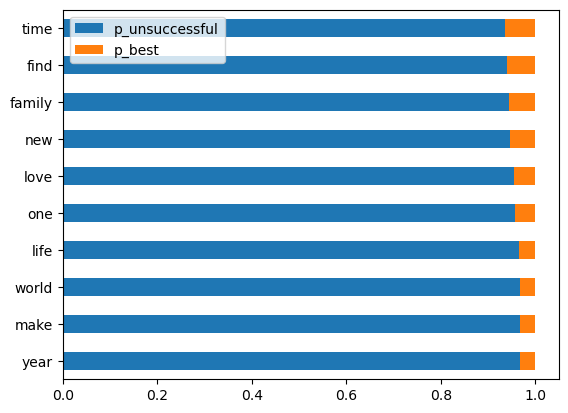

In [11]:
best_words = ex.uni_id_best_seller(train)

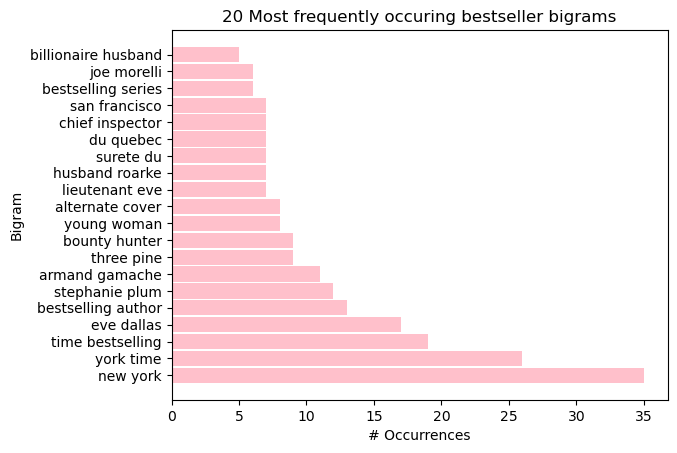

In [12]:
ex.best_bigrams(best_words)

<div class="alert alert-block alert-success">
<b>Takeaways</b>

### Which words/ngrams appear more often in summaries with a negative sentiment?

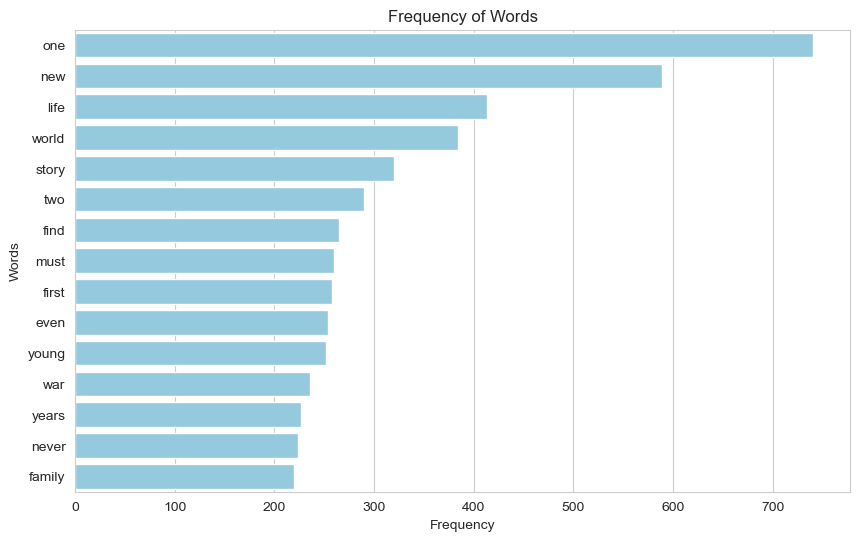

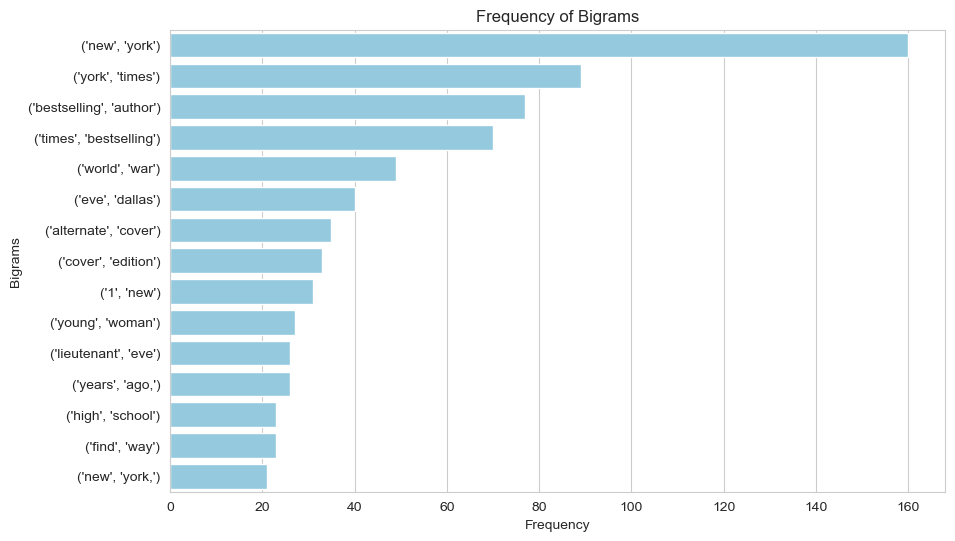

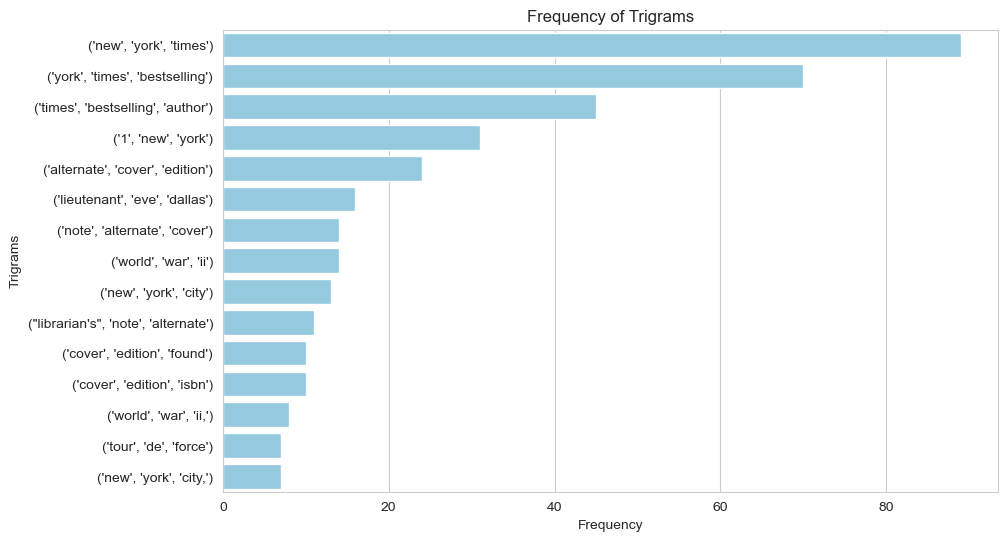

In [13]:
ex.explore_question_2(train)

<div class="alert alert-block alert-success">
<b>Takeaways</b>